In [147]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import dill
import loss_functions as lf
from Optimal_Stopping_Object import ModelConstructor, ModelFitting
import constants
import data_visualization as dv
from initializer import InitialThangs
from copy import deepcopy
import plot_functions as pf
import constants
import read_data_functions as rdf

wheel = dv.ColorWheel()
it = InitialThangs(experiment="Exp1")
%load_ext autoreload
%autoreload 2
plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')
# #* True Parameters load
# with open(constants.MODEL_INPUT_PATH / 'model_input_dict.pkl','rb') as f:
#     model_input_dict = dill.load(f)
# true_parameters = [np.nanmedian(v) for k,v in model_input_dict.items() if "agent" not in k] 
# #* Bootstrap Load
# with open(constants.MODEL_INPUT_PATH / 'bootstrap_parameter_distribution.pkl','rb') as f:
#     parameter_distribution = dill.load(f)    
# with open(constants.MODEL_INPUT_PATH / 'bootstrap_results.pkl','rb') as f:
#     results = dill.load(f)    
# with open(constants.MODEL_INPUT_PATH / 'participant_ids.pkl','rb') as f:
#     participant_ids = dill.load(f)        
#* Comparison Targets load
with open(constants.MODEL_INPUT_PATH / 'participant_median_movement_onset_time.pkl','rb') as f:
    participant_median_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_sd_movement_onset_time.pkl','rb') as f:
    participant_sd_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_wins.pkl','rb') as f:
    participant_wins = dill.load(f)  
participant_perc_wins = (participant_wins/it.num_trials)*100
with open(constants.MODEL_INPUT_PATH / 'participant_incorrects.pkl','rb') as f:
    participant_incorrects = dill.load(f)  
participant_perc_incorrects = (participant_incorrects/it.num_trials)*100

with open(constants.MODEL_INPUT_PATH / 'participant_indecisions.pkl','rb') as f:
    participant_indecisions = dill.load(f)  
participant_perc_indecisions = (participant_indecisions/it.num_trials)*100

np.random.seed(0)


# group = rdf.generate_subject_object_v3('Exp1', "All Trials")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
SAVE_PATH = Path("D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures\paper")
EXPERIMENT = "Exp1"
it = InitialThangs(EXPERIMENT)

BOOTSTRAPPED_MODELS = True
if BOOTSTRAPPED_MODELS:
    p = "bootstrapped"
else:
    p = "warmstart"
    
path = constants.MODELS_PATH / f"{p}_models"
model_names = ["Base","Optimal","Suboptimal",]
model_results = []
model_inputs = []
for model in model_names:
    results_path = list(path.glob(f"{EXPERIMENT}_{model.lower()}_{p}_results*"))[-1]
    inputs_path = list(path.glob(f"{EXPERIMENT}_{model.lower()}_{p}_inputs*"))[-1]
    print(results_path)
    print(inputs_path)
    temp_results = pd.read_pickle(path / results_path)
    try:
        temp_results['num_parameters'] = 7 + temp_results["fit_parameters"].apply(len) # Add on number of parameters
    except KeyError:
        temp_results['num_parameters'] = 7
        
    # temp_results['bic'] = 30*np.log(temp_results['Loss']/30) + temp_results['num_parameters']*np.log(30)
    temp_results['bic'] = temp_results['num_parameters']*np.log(30) + 2*np.log(temp_results['Loss'])
    temp_results['aic'] = 2*temp_results['num_parameters'] + 2*np.log(temp_results['Loss'])
    temp_inputs = pd.read_pickle(path / inputs_path)
    model_results.append(temp_results)
    model_inputs.append(temp_inputs)

d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_base_bootstrapped_results_2023_11_30_08_59_44.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_base_bootstrapped_inputs_2023_11_30_08_59_44.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_optimal_bootstrapped_results_2023_11_28_01_16_30.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_optimal_bootstrapped_inputs_2023_11_28_01_16_30.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_suboptimal_bootstrapped_results_2023_11_27_16_53_43.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_suboptim

In [168]:
model_results[2]['bic']

0       43.017943
1       42.047869
2       43.172840
3       42.497061
4       42.884417
          ...    
9995    42.401798
9996    43.066010
9997    43.320738
9998    43.671550
9999    42.859196
Name: bic, Length: 10000, dtype: float64

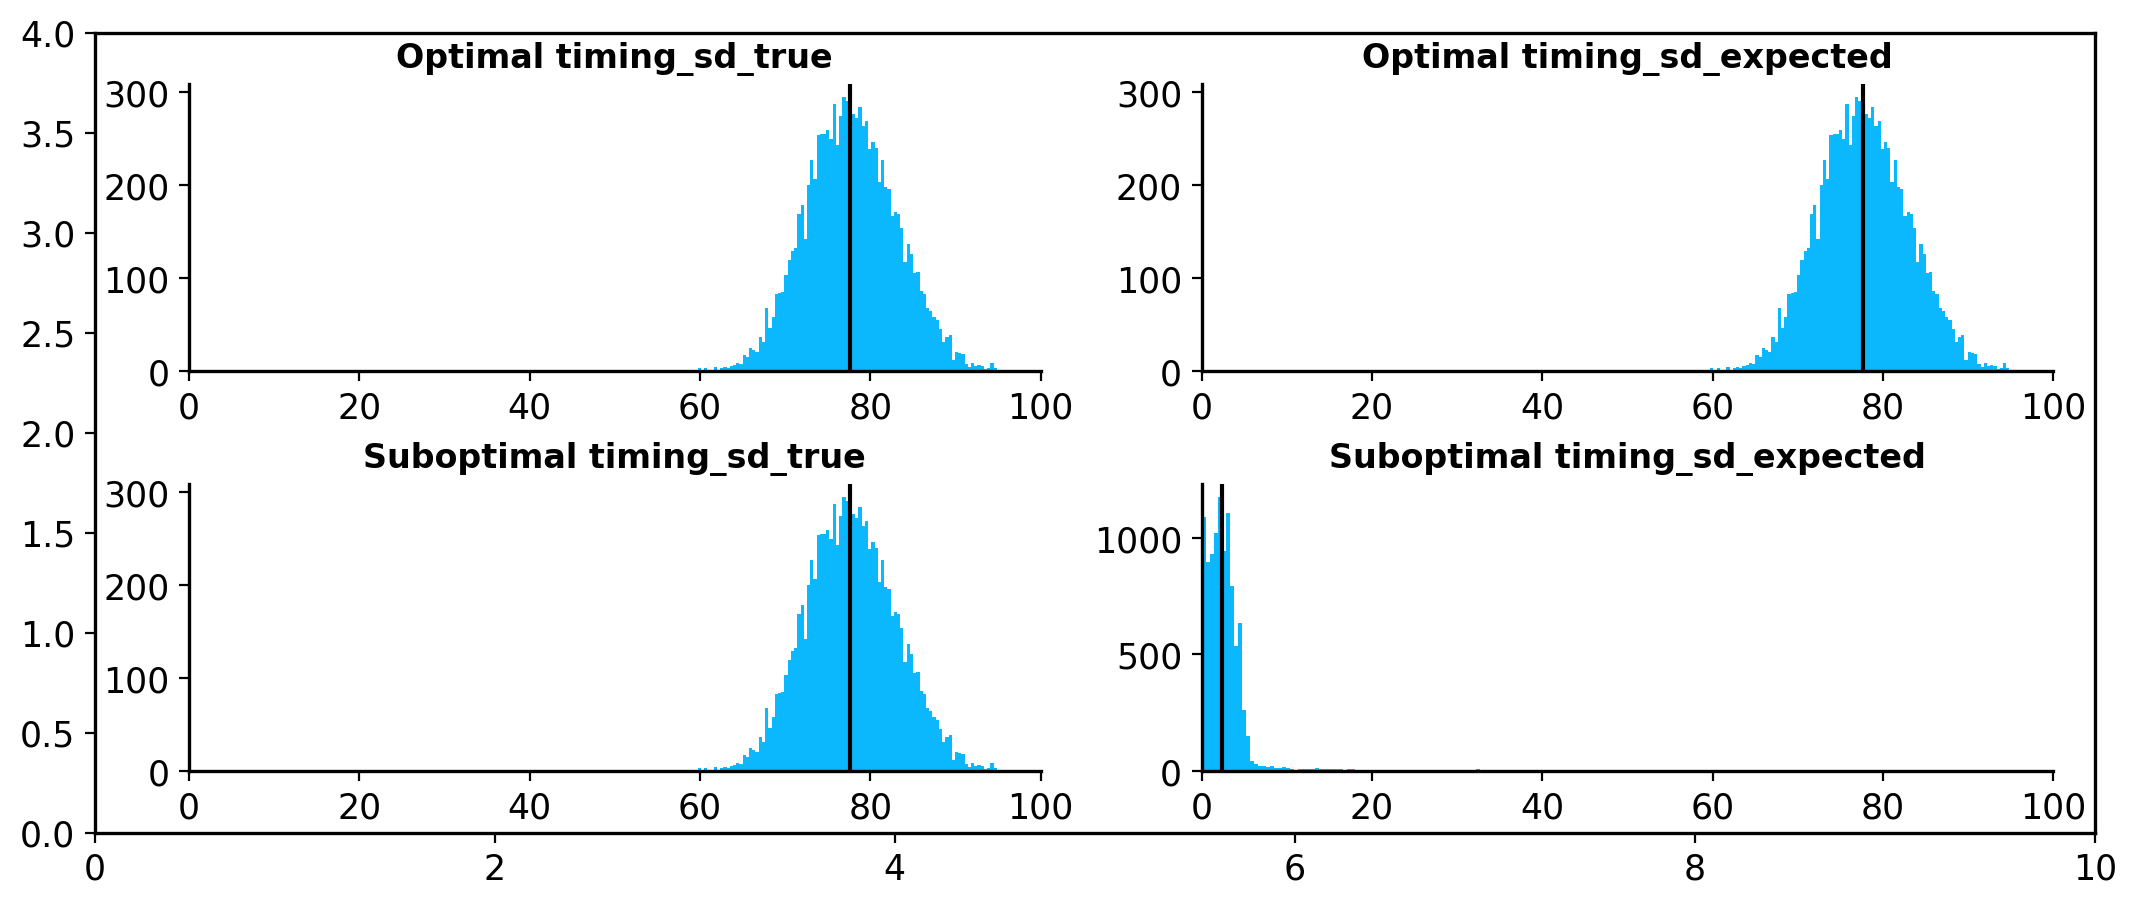

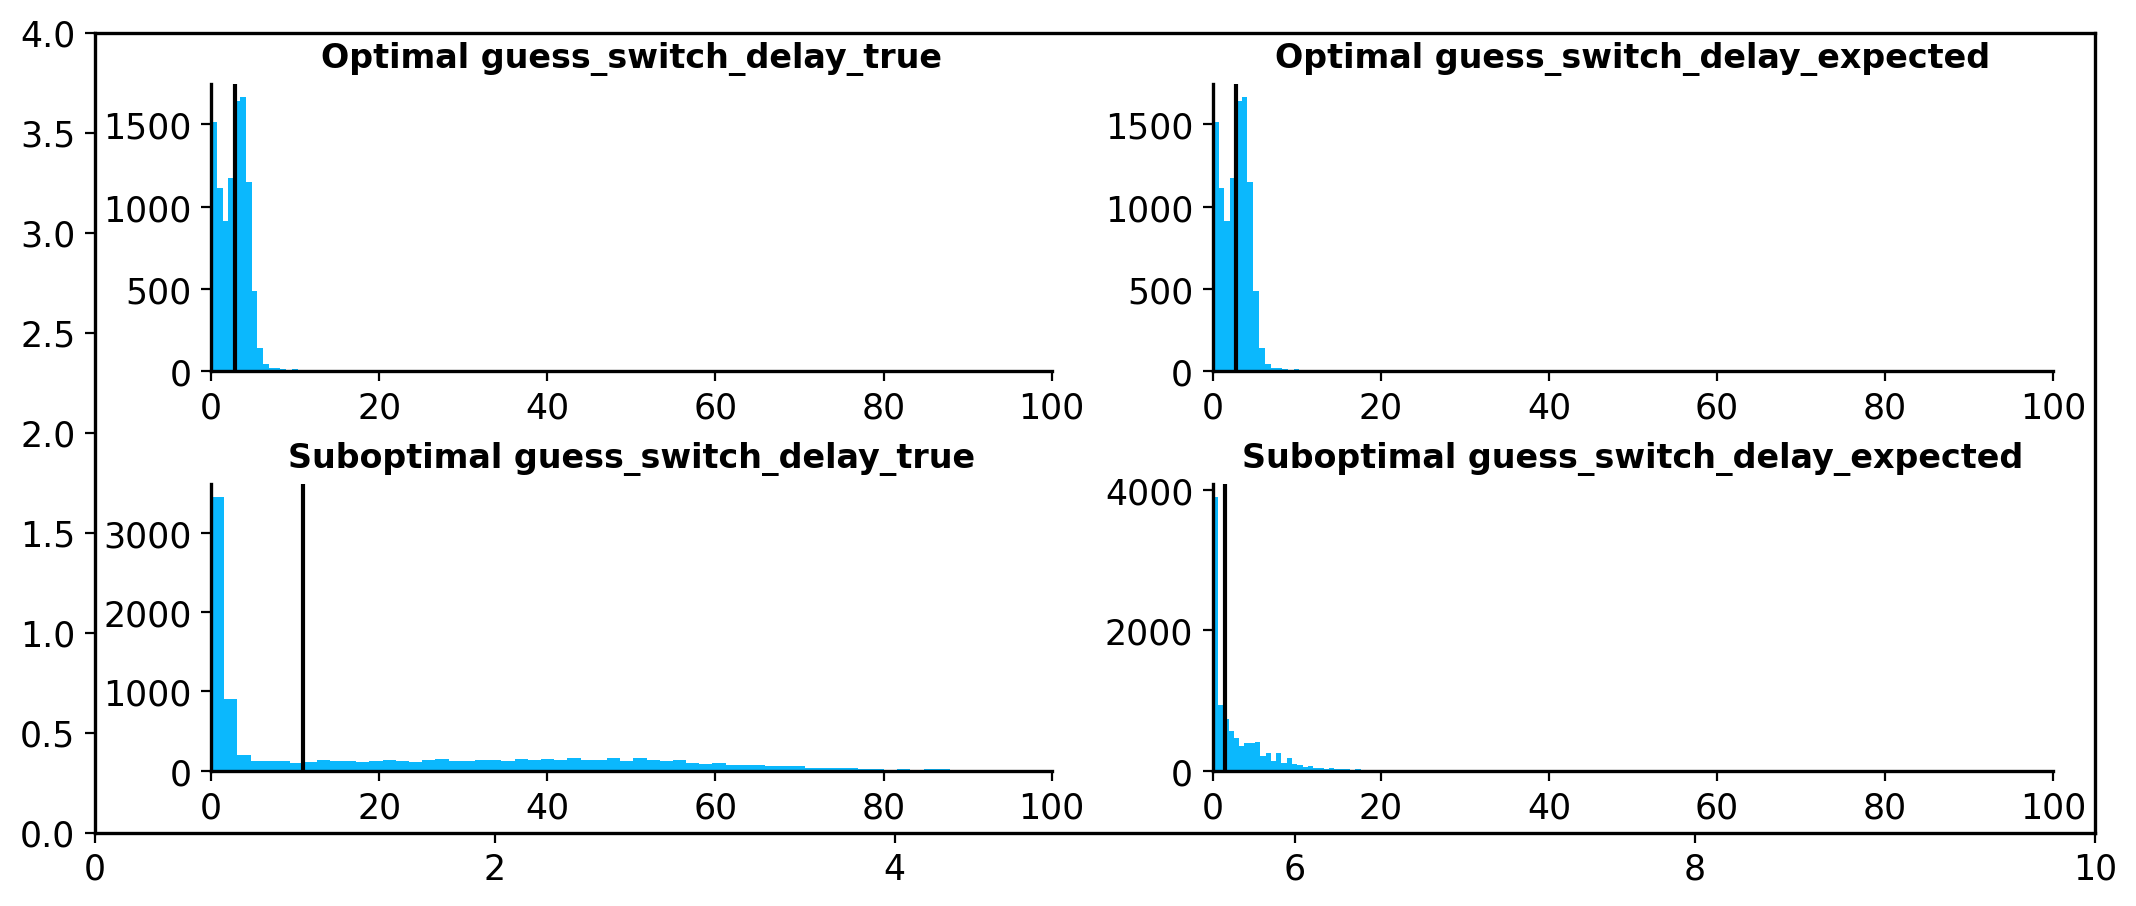

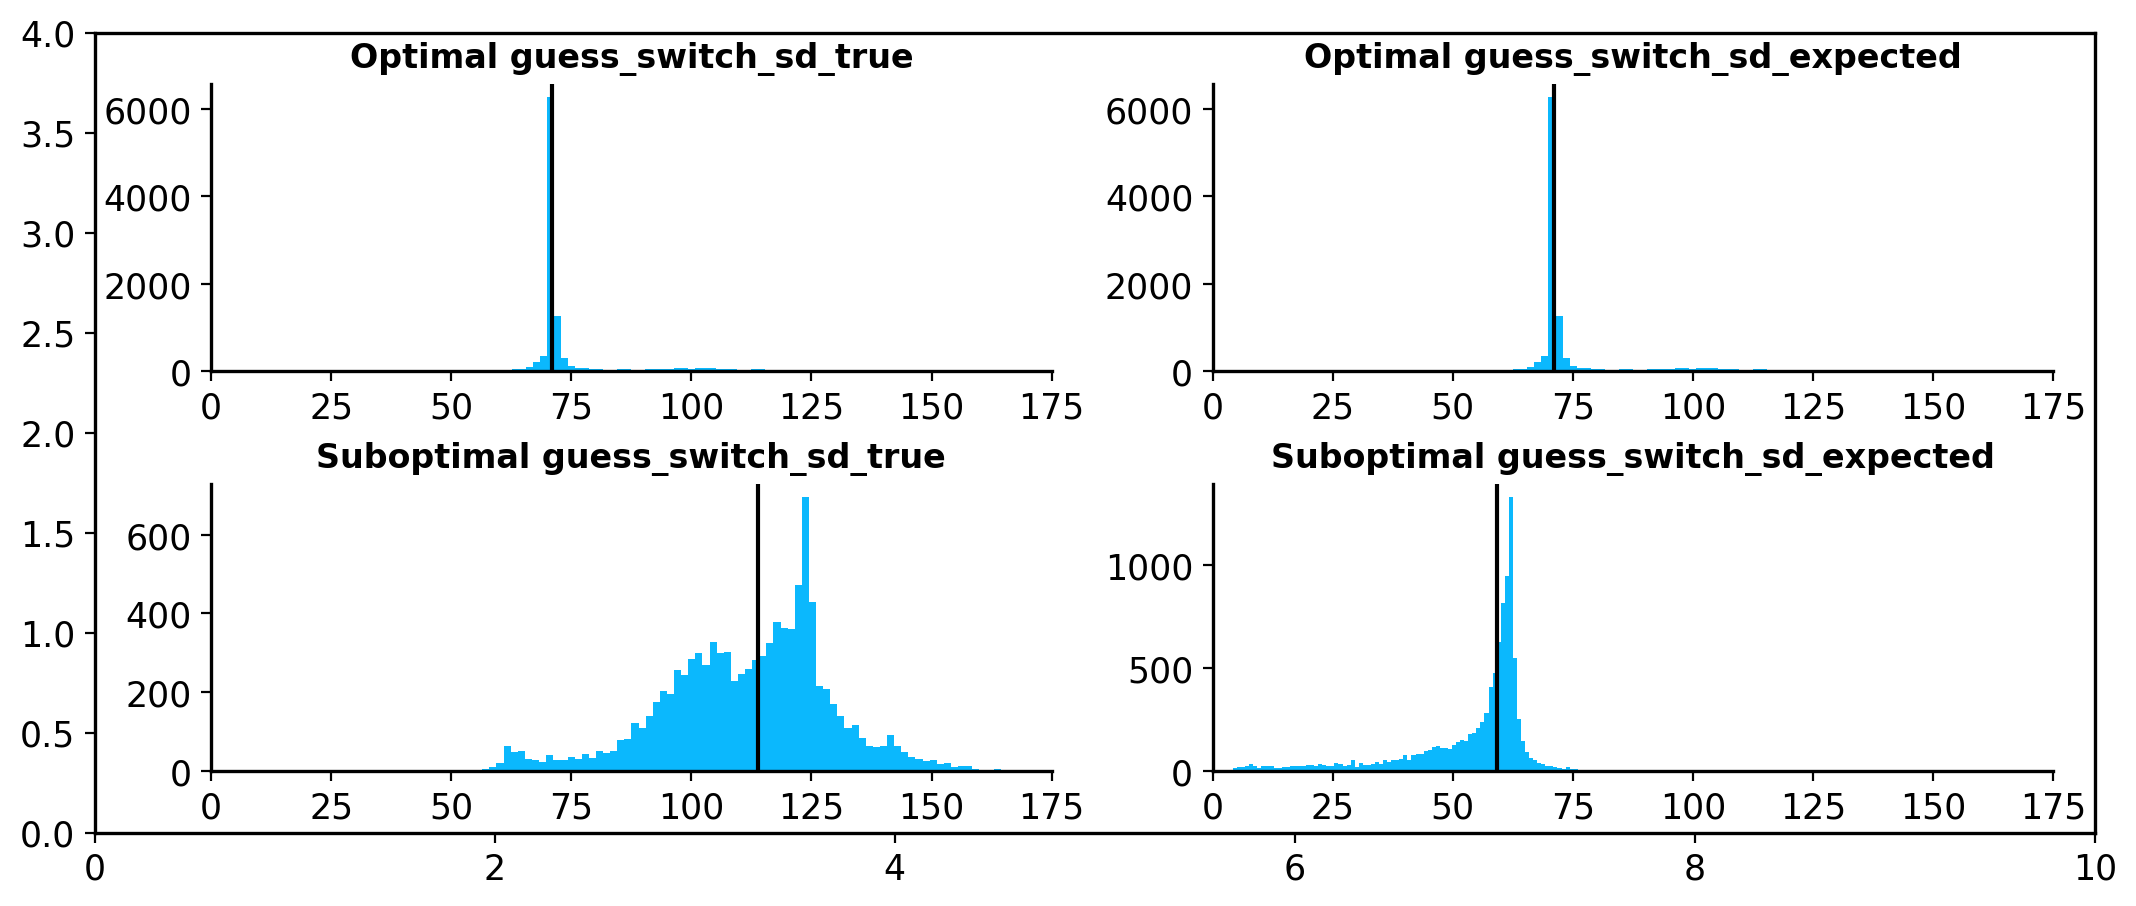

In [169]:
columns = ["timing_sd","guess_switch_delay",
           "guess_switch_sd",]
model_name_to_figure = {model_names[1]:"ab", model_names[2]:"cd"}
xlims = {'timing_sd':(0,100),"guess_switch_delay":(0,100), "guess_switch_sd":(0,175)}
for i,col_name in enumerate(columns):
    fig = pf.NewFigure("ab;cd",figsize = (10,4),dpi=200)
    for df_inputs,model_name in zip(model_inputs[1:],model_names[1:]):
        col = np.stack(df_inputs[col_name].to_numpy()).squeeze()
        for j in range(2): # Looping through true and expected
            if col.ndim == 1:
                hist = col
                median = np.nanmedian(col)
                sd = np.nanstd(col)
                
            elif col.ndim == 2:
                hist = col[:,j]
                median = np.nanmedian(col[:,j])
                sd = np.nanstd(col[:,j])
            elif col.ndim == 3:
                hist = col[:,j,0]
                median = np.nanmedian(col[:,j,0])
            if j == 0:
                end_title = "_true"
            else:
                end_title = "_expected"
            idx = model_name_to_figure[model_name][j]
            fig.axes[idx].hist(hist,align='mid',bins=100)
            fig.axes[idx].axvline(median)
            fig.axes[idx].set_title(model_name + " " + col_name + end_title, fontsize = 12)
            fig.axes[idx].set_xlim(xlims[col_name])
                # ax.set_xlim(0,16)
                # fig.remove_figure_borders()
    
    plt.show()
        

Pair Plot

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_22220\421609377.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dv.Pair_Plot(parameter_array=np.array(param_array),labels=columns)


ValueError: could not broadcast input array from shape (10000,2,6) into shape (10000,2)

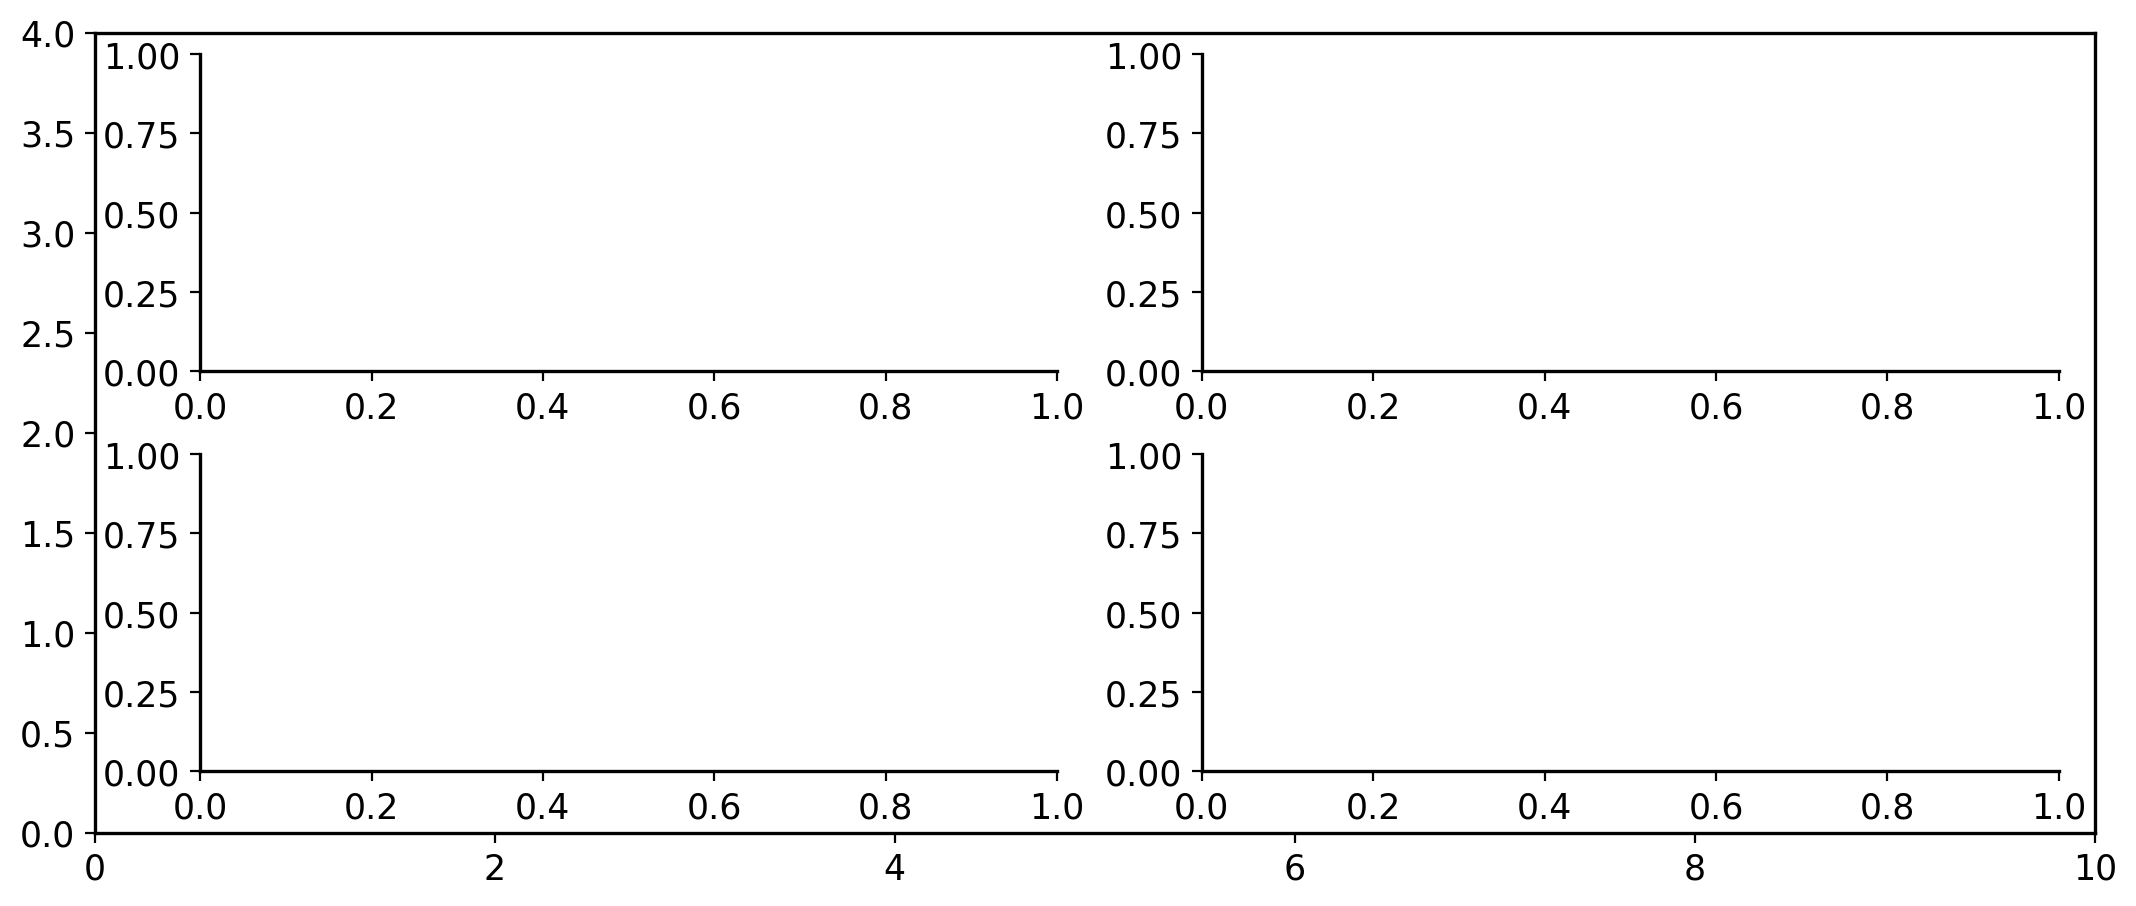

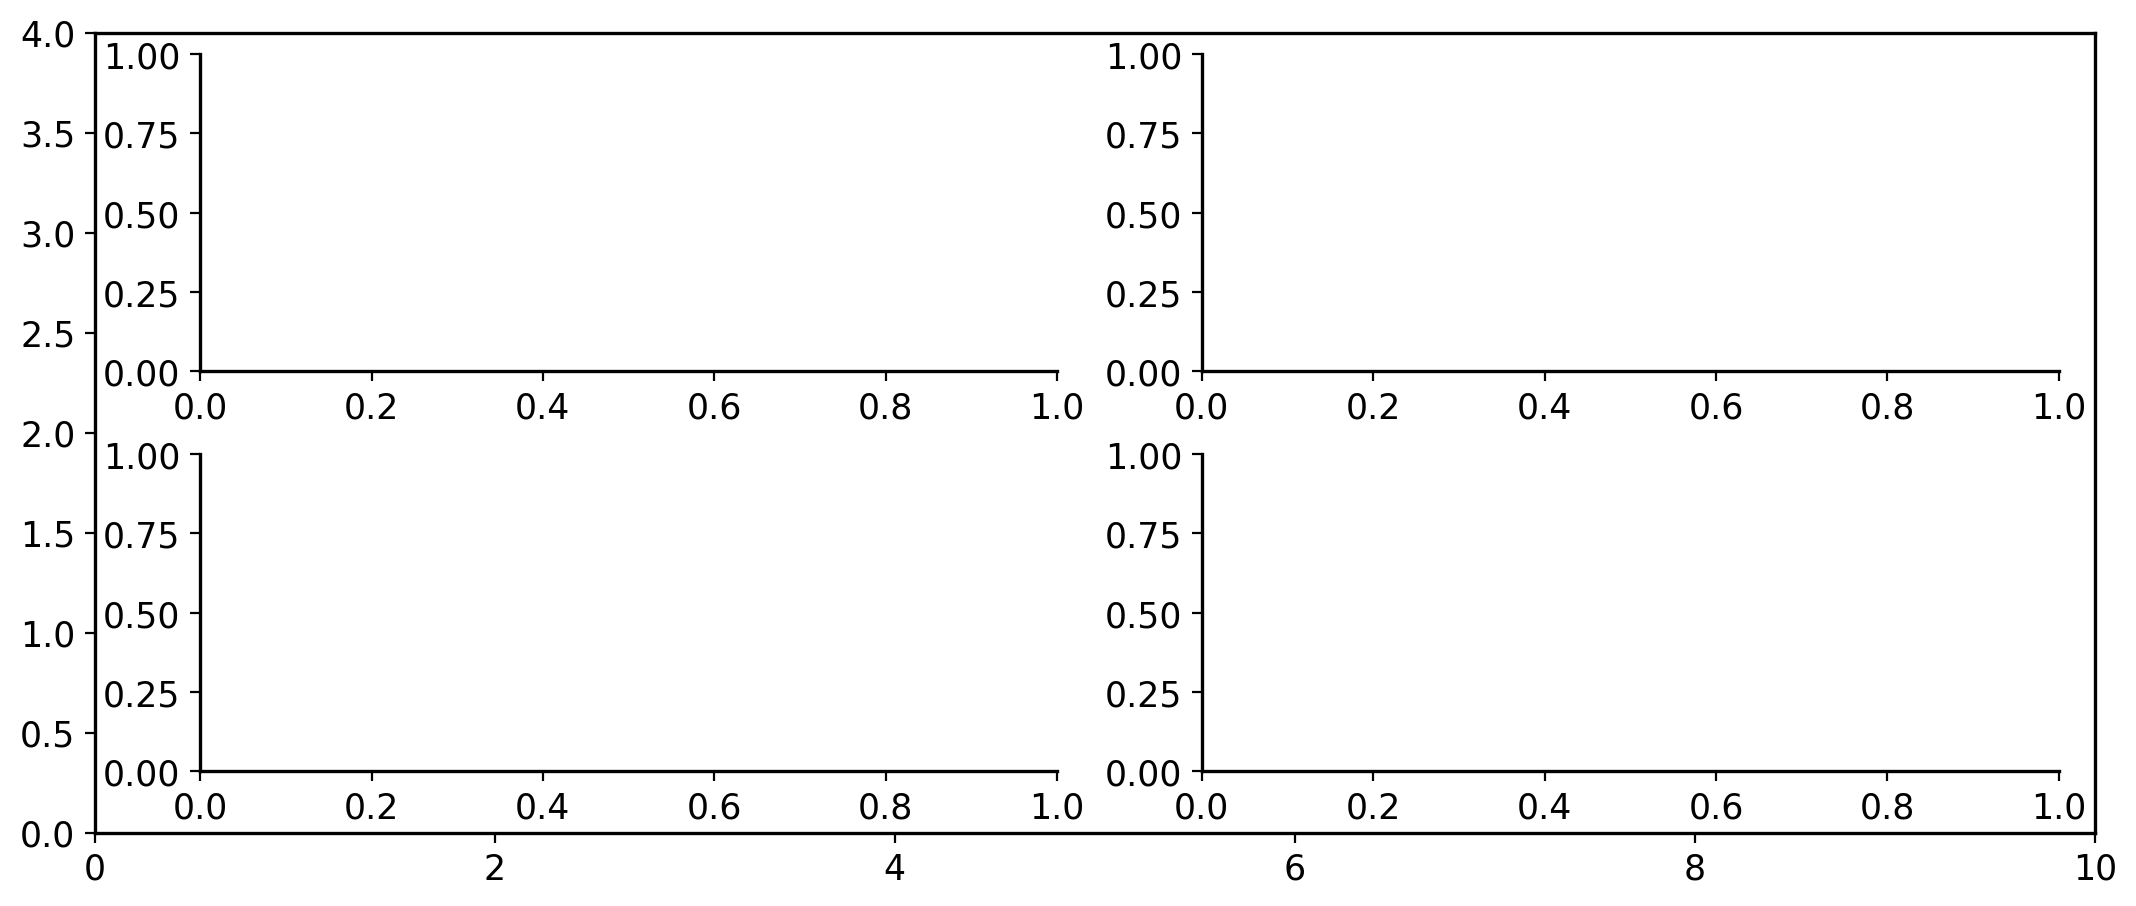

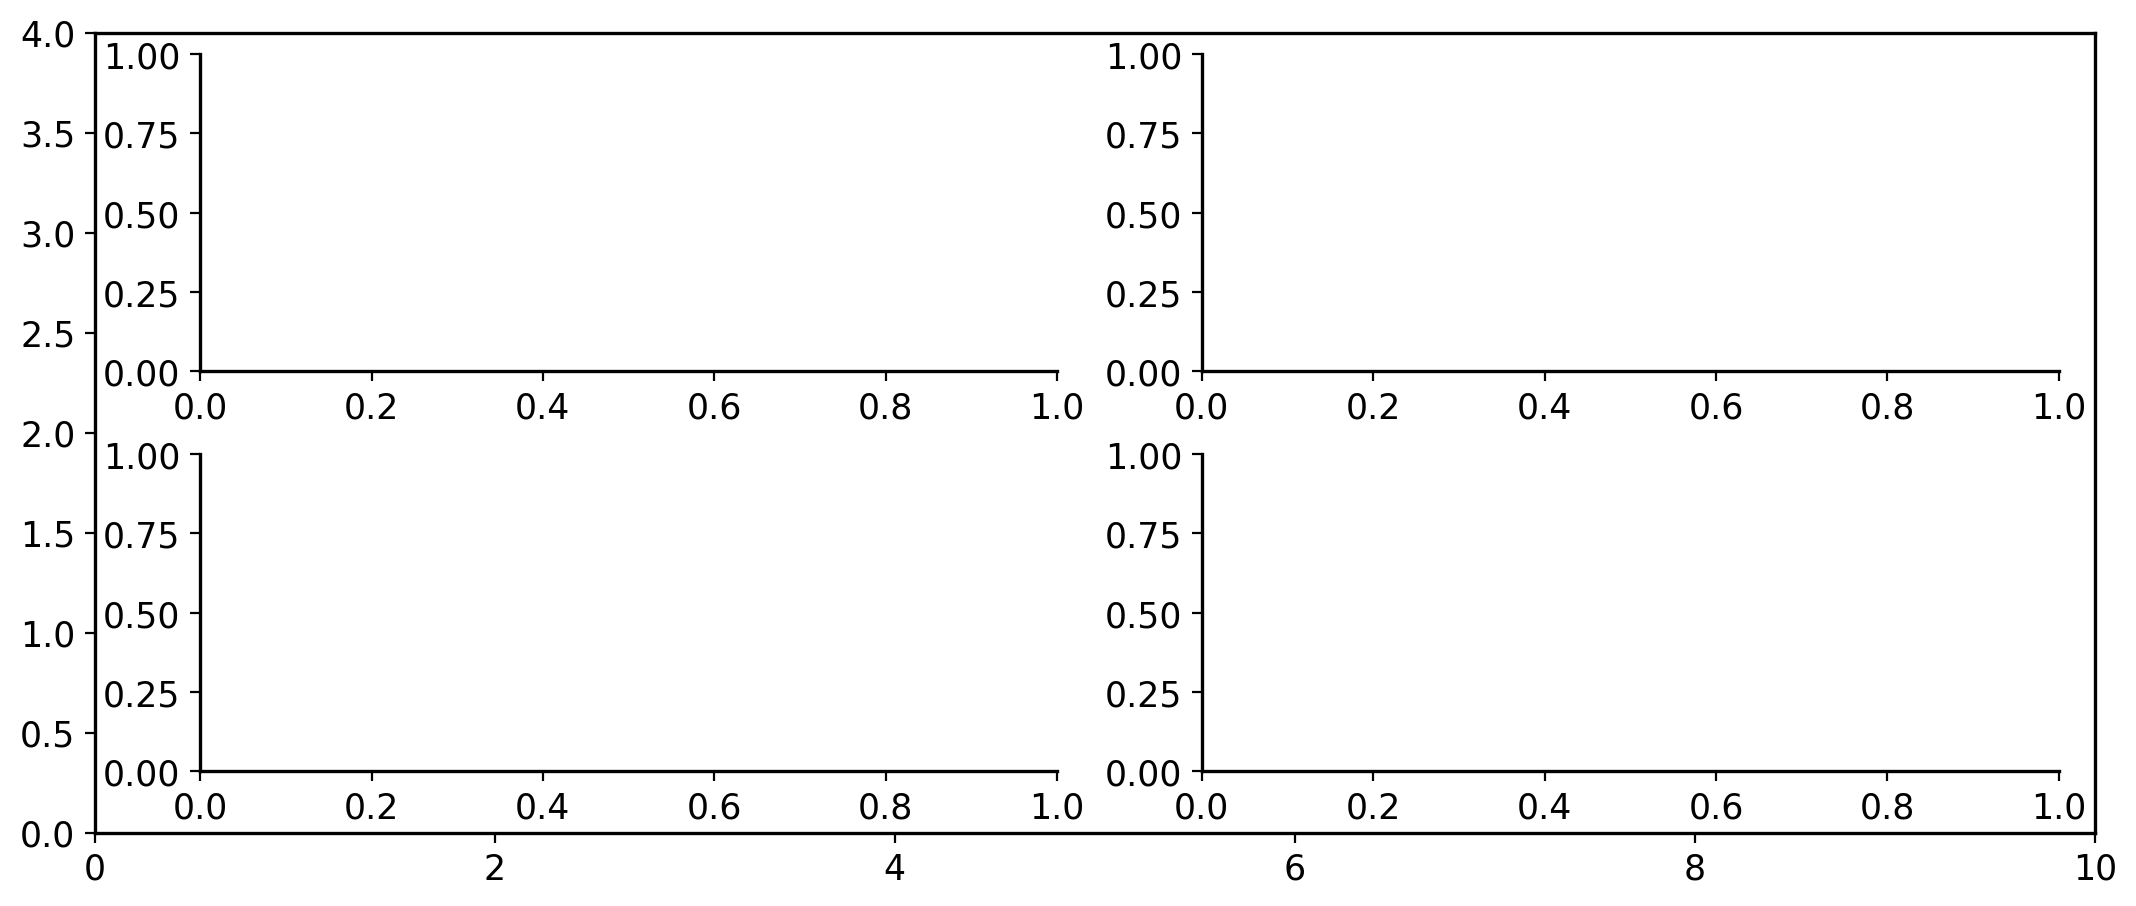

In [206]:
columns = ["timing_sd","guess_switch_delay",
           "guess_switch_sd",]
model_name_to_figure = {model_names[1]:"ab", model_names[2]:"cd"}
xlims = {'timing_sd':(0,100),"guess_switch_delay":(0,100), "guess_switch_sd":(0,175)}
param_array = []
for i,col_name in enumerate(columns):
    fig = pf.NewFigure("ab;cd",figsize = (10,4),dpi=200)
    for df_inputs,model_name in zip(model_inputs[2:],model_names[2:]):
        col = np.stack(df_inputs[col_name].to_numpy()).squeeze()
        param_array.append(col)
        
dv.Pair_Plot(parameter_array=np.array(param_array),labels=columns)

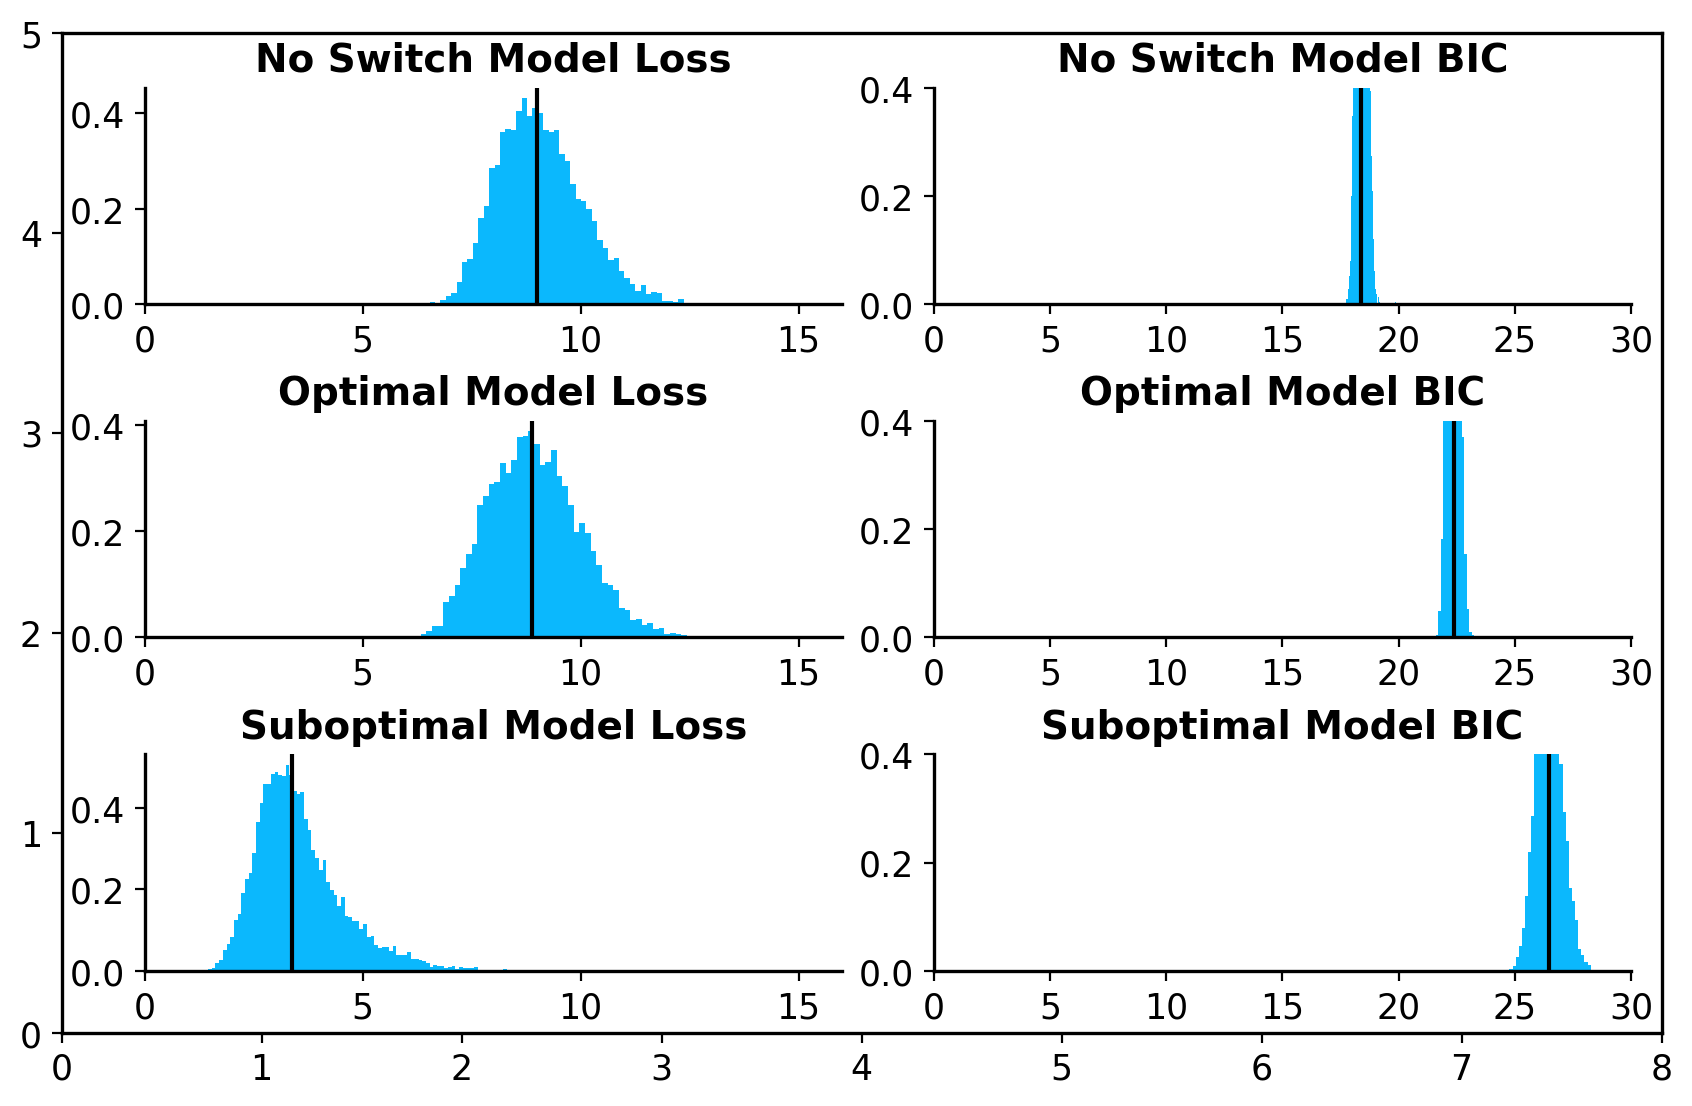

In [184]:
columns = ["Loss","aic",]
loss = []
bic = []
for i in range(len(model_results)):
    loss.append(np.stack(model_results[i]["Loss"].to_numpy()))
    bic.append(np.stack(model_results[i]["aic"].to_numpy()))

loss_titles = ["No Switch Model Loss", "Optimal Model Loss", "Suboptimal Model Loss"]
bic_titles = ["No Switch Model BIC", "Optimal Model BIC", "Suboptimal Model BIC"]
fig = pf.NewFigure("ab;cd;ef",figsize = (8,5),dpi=200)
ax1,ax2,ax3,ax4,ax5,ax6 = fig.axes.values()
for i,ax in enumerate(fig.axes.values()):
    if i%2==0:
        loss[i//2] = np.where(loss[i//2]>40,np.nan,loss[i//2])
        ax.hist(loss[i//2],align='mid',bins=100,density=True)
        ax.axvline(np.nanmedian(loss[i//2]))
        ax.set_title(loss_titles[i//2], fontsize=14)
        ax.set_xlim(0,16)
    else:
        # bic[i//2] = np.where(bic[i//2]>40,np.nan,bic[i//2])
        ax.hist(bic[i//2],align='mid',bins=100,density=True)
        ax.axvline(np.median(bic[i//2]))
        ax.set_title(bic_titles[i//2], fontsize=14)
        ax.set_xlim(0,30)
        ax.set_ylim(0,0.4)
        # fig.remove_figure_borders()
# plt.show()

# Find Median and Confidence Intervals

In [172]:
np.median(np.stack(model_results[0]["median_movement_onset_time"].to_numpy()),axis=0)

array([1243.47586892, 1170.64925472, 1196.16083702, 1165.34966906,
        886.02200948, 1103.47332568])

In [195]:
plot = False
col_names = ["median_movement_onset_time", "sd_movement_onset_time",
             "indecisions", "wins", "incorrects"]
base_medians = {}
base_intervals = {}
for i,col_name in enumerate(col_names):
    arr = np.stack(model_results[0][col_name].to_numpy())
    base_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    base_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]})    
    if plot:
        fig,axs = plt.subplots(2,3,dpi=150,figsize = (10,4))
        faxs = axs.flatten()
        for j in range(arr.shape[1]):
            ax = faxs[j]
            ax.hist(arr[:,j])
            ax.set_title(it.trial_block_titles[j], fontsize=8)
            if i>1:
                ax.set_xlim(0,100)
        fig.suptitle(col_name)
        plt.tight_layout()

optimal_medians = {}
optimal_intervals = {}
for i,col_name in enumerate(col_names):
    arr = np.stack(model_results[1][col_name].to_numpy())
    optimal_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    optimal_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]})     
    
    
suboptimal_medians = {}
suboptimal_intervals = {}
for i,col_name in enumerate(col_names):
    arr = np.stack(model_results[2][col_name].to_numpy())
    suboptimal_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    suboptimal_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]}) 

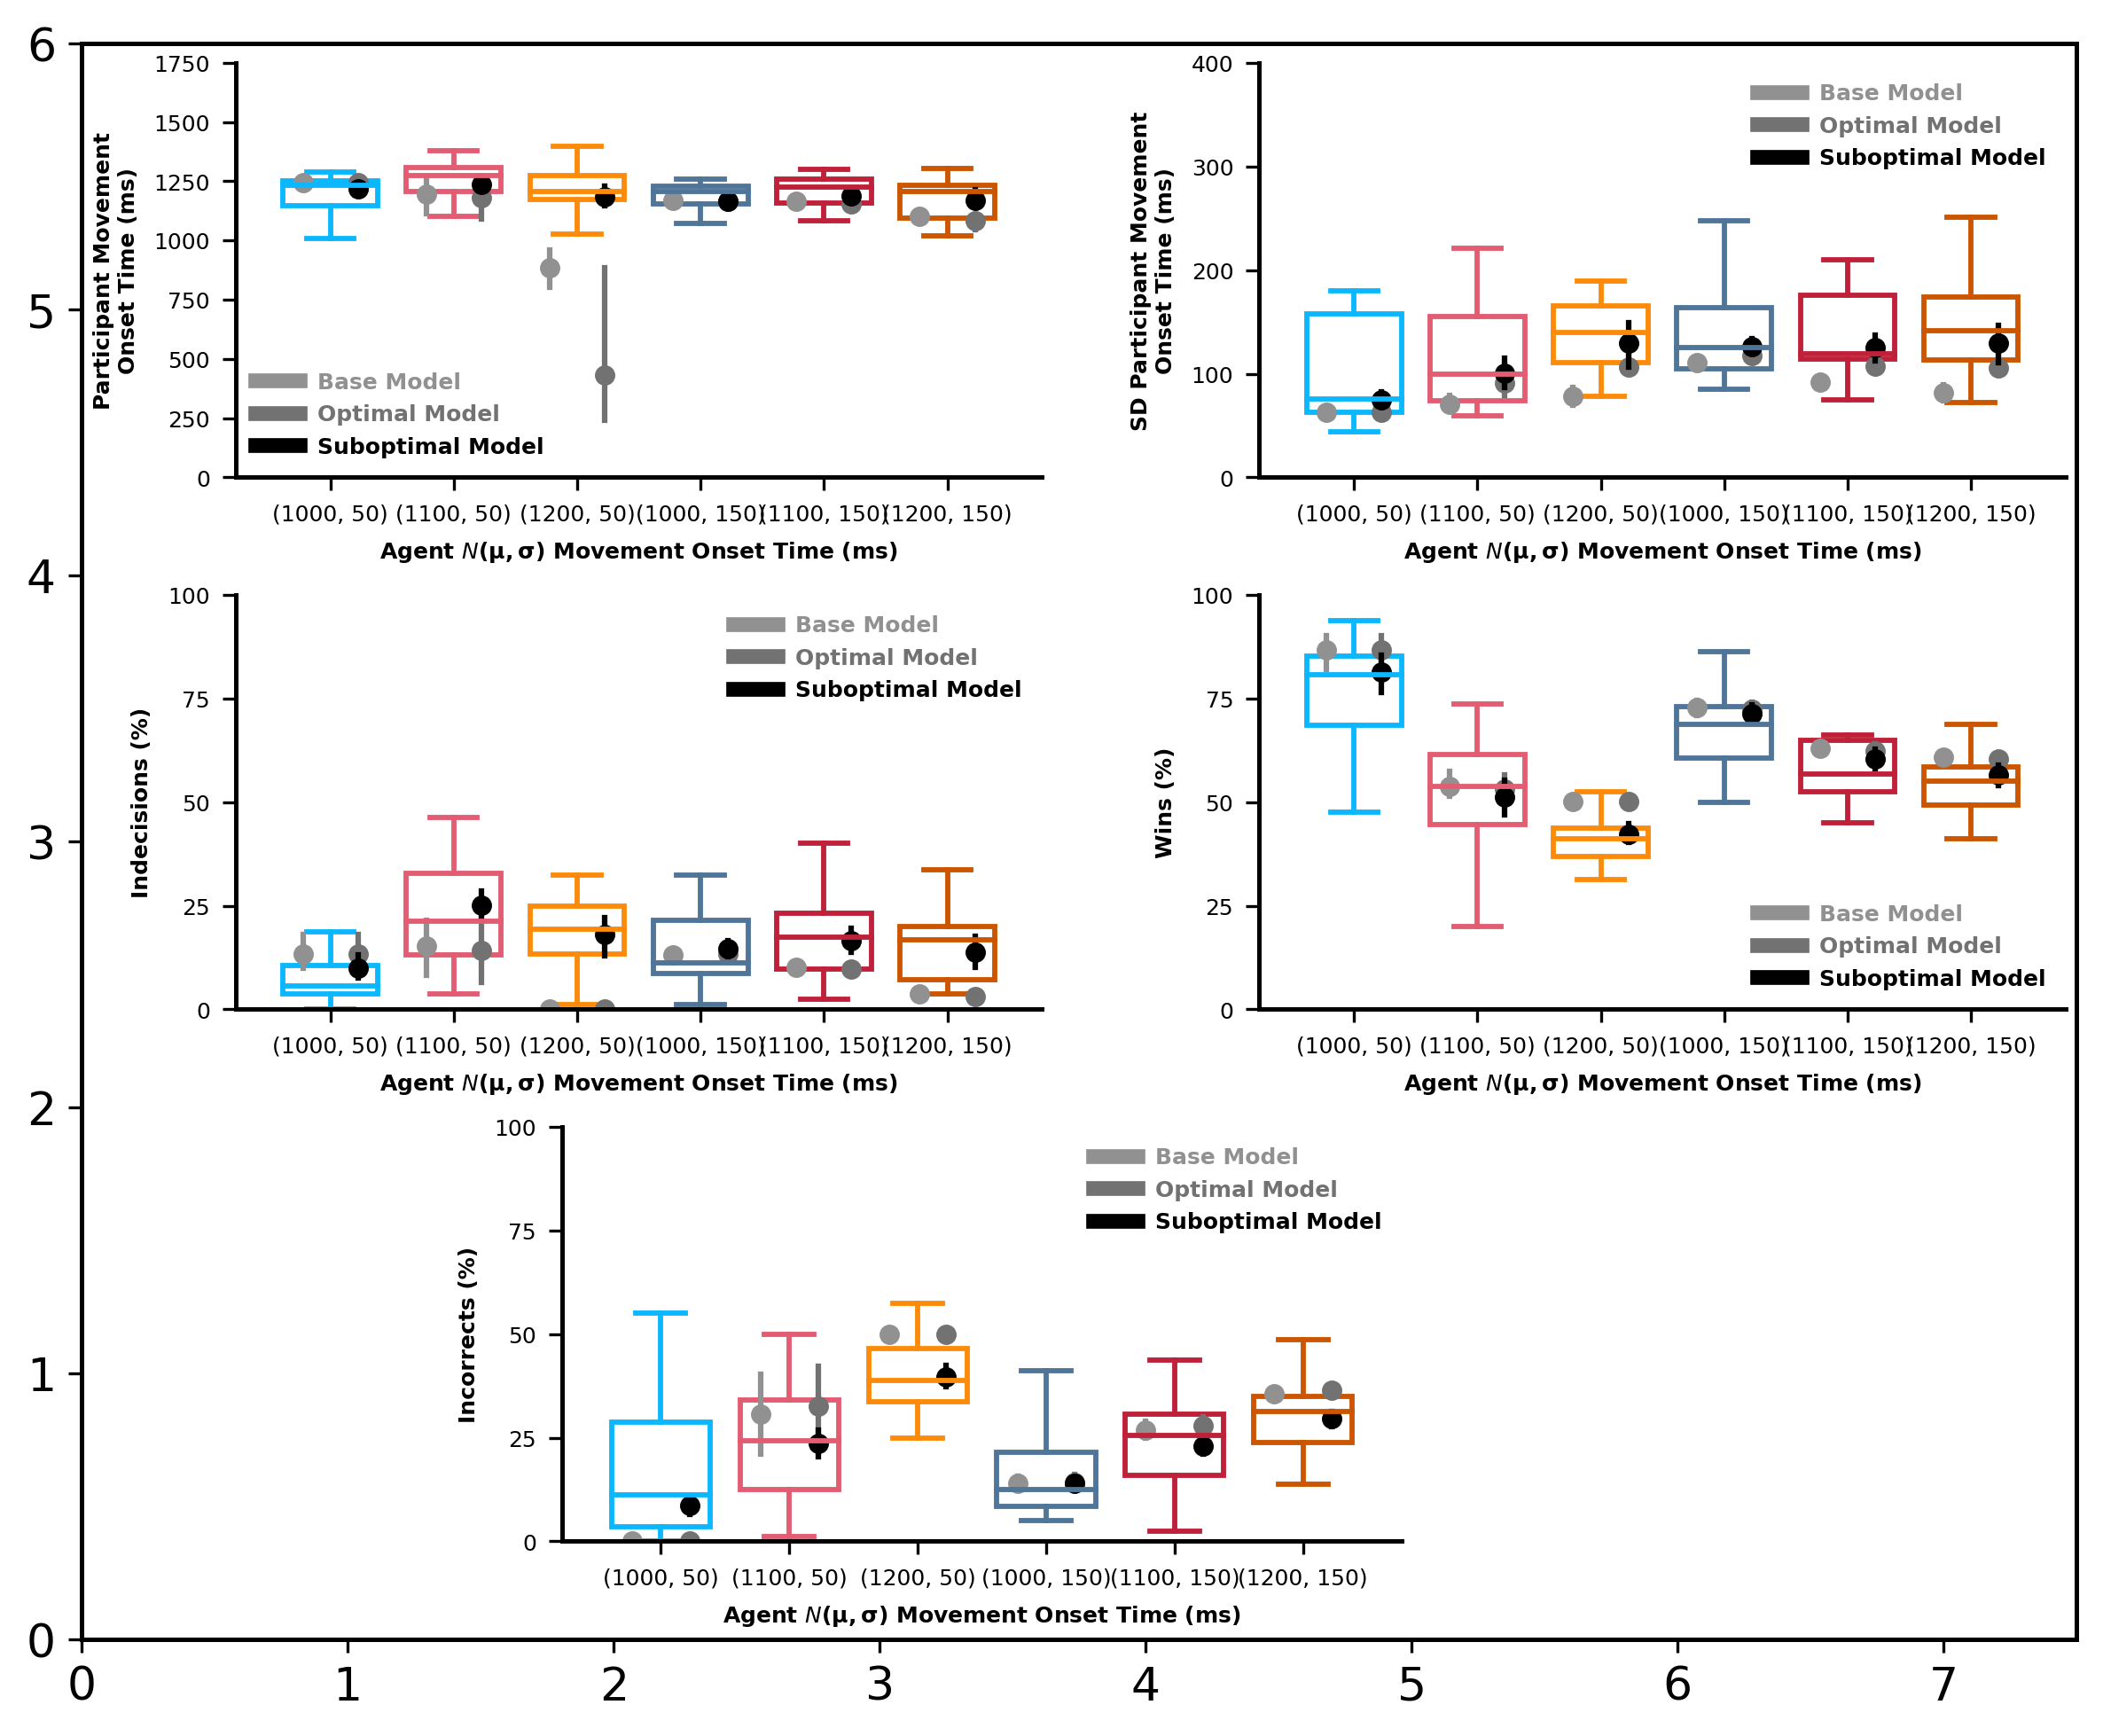

In [222]:
save_path = Path(
    r"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures"
)
w, h = 7.5, 6
bw = (
    0.35 * w
) / it.num_blocks  # box widths of all boxes combined takes up 30% of the width
mult_w, div_w = 0.053, 2.3
div_h = 1.75
xlocs = np.linspace(0, w / div_w, num=len(it.trial_block_titles))
legend_fontsize = 6
ticklabel_fontsize = 6
suptitle_fontsize = 6
label_fontsize = 6
markersize = 0.1*(w*h)

metrics = np.array(
    [
        participant_median_movement_onset_time,
        participant_sd_movement_onset_time,
        participant_perc_indecisions,
        participant_perc_wins,
        participant_perc_incorrects,
    ]
)[
    :, :, [0, 2, 4, 1, 3, 5]
]  # Rearranging axes to get the order I want
ylocs = (
    [np.arange(0, 1751, 250)] + [np.arange(0, 401, 100)] + [np.arange(0, 101, 25)] * 3
)
ylabels = [
    "Participant Movement\nOnset Time (ms)",
    "SD Participant Movement\nOnset Time (ms)",
    "Indecisions (%)",
    "Wins (%)",
    "Incorrects (%)",
]
ylims = [(0, 1750)] + [(0, 400)] + [(0, 100)] * 3

model_labels = ["Base Model", "Optimal Model", "Suboptimal Model"]
# save_names = ["exp1_results_only_optimal_model", 'exp1_results_both_models','exp1_results_statistics',]
suptitles = ["Model Results", "Model Results", "Participant Behaviour"]
legend_locs = (0.58, 0.86)
median_dicts = [base_medians, optimal_medians, suboptimal_medians]
interval_dicts = [base_intervals, optimal_intervals, suboptimal_intervals]

mosaic = "aaabbb;cccddd;.eee.."
fig = pf.NewFigure(mosaic, dpi=300, figsize=(w, h))
axs = list(fig.axes.values())
model_colors = [wheel.grey, wheel.dark_grey, wheel.black]
# * Looping axes for each metric
for i, (ax, col_name) in enumerate(zip(axs, col_names)):
    # * Looping each experimental condition
    for j in range(len(xlocs)):
        dv.boxplot(
            ax,
            xlocs[j],
            metrics[i, :, j],
            color=constants.xticklabel_colors_means[j],
            data_color=constants.xticklabel_colors_means[j],
            box_lw=1.4
        )
        for k, (model_medians, model_intervals) in enumerate(
            zip(median_dicts, interval_dicts)
        ):
            if k == 0:
                shift = -bw / 3
            if k == 1:
                shift = +bw / 3
            pf.plot_boostrapped_model_results(
                ax,
                xlocs[j] + shift,
                y=model_medians[col_name][j],
                percentiles=model_intervals[col_name][:, j],
                horizontal_lw=0,
                markersize=markersize,
                color=model_colors[k],
            )

    # dv.jitter_array(ax=ax,x_positions=xlocs,data=metrics[i,:,:].T,
    #                 data_color = constants.xticklabel_colors_means,
    #                 data_edge_color = wheel.lighten_color(wheel.light_grey,1.2),
    #                 noise_scale=0.06, include_mean = False, circle_size=40)

    ax.set_ylim(ylims[i])
    ax.set_xticks(xlocs, labels=constants.xticklabels, fontsize=ticklabel_fontsize)
    ax.set_yticks(ylocs[i], labels=ylocs[i], fontsize=ticklabel_fontsize)
    ax.set_xlabel(it.xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabels[i], fontsize=label_fontsize)
    dv.legend(ax, labels=model_labels, colors=model_colors,fontsize=legend_fontsize)
    # [ticklabel.set_color(color) for (color,ticklabel) in zip(constants.xticklabel_colors_means,ax.xaxis.get_ticklabels())]

# fig.axes['a'].set_xlabel("xlabela")
# fig.add_all_letters()
fig.fig.facecolor = 1
# fig.pad_fig(w_pad=-2,h_pad=0,w_space=-2,h_space=0.1)
# for ax_label in ["c", "d", "e"]:
#     fig.adjust_position(fig.axes[ax_label], (-0.3, 0))
#     fig.adjust_size(fig.axes[ax_label], (0.35, 0))
# # fig.fig.subplots_adjust(right=0.8)

plt.show()
fig.savefig(save_path / "test.png")

In [190]:
bbox = fig.axes['c'].bbox.transformed(fig.axmain.transData.inverted())
bbox

Bbox([[0.5231144444444445, 0.4777811111111111], [4.405284527774108, 3.9599966666666657]])

In [192]:
fig.axes['a'].yaxis.label.get_window_extent().transformed(fig.axes['a'].transAxes.inverted())

Bbox([[-0.13633219687980563, 0.2011600851820392], [-0.07608472525995123, 0.7988399148179606]])

In [193]:
fig.axes['a'].yaxis.label.get_window_extent().transformed(fig.fig.dpi_scale_trans.inverted())

Bbox([[0.04167000000000002, 5.22326388888889], [0.3870033333333335, 7.3045138888888905]])